# Tutorial for REU data processing and visualization
### Authors: Yu Huang, Sungduk Yu


## Install and load python packages

#### Please click the "+" button on the leftup corner to launch a terminal, copy the below commands after "!" and run them on the terminal if you cannot directly import them

In [1]:
# ! mamba install xesmf 

In [1]:
import gcsfs
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cftime
import xesmf as xe
from tqdm import tqdm


## Load dataset from Google Cloud

#### Open Google Cloud Storage File System


In [2]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored


In [3]:
fs.ls("gs://leap-persistent/sungdukyu")

['leap-persistent/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.test.input.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.test.output.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent/sungdukyu/testing']

#### Open the file you want using xarray


In [4]:
mapper = fs.get_mapper('leap-persistent/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr')


#### Check which variables are included in the dataset & the dimensions/shapes of the variables


In [5]:
ds

<xarray.Dataset>
Dimensions:         (sample: 210240, ncol: 384, lev: 60)
Dimensions without coordinates: sample, ncol, lev
Data variables: (12/16)
    cam_out_FLWDS   (sample, ncol) float64 ...
    cam_out_NETSW   (sample, ncol) float64 ...
    cam_out_PRECC   (sample, ncol) float64 ...
    cam_out_PRECSC  (sample, ncol) float64 ...
    cam_out_SOLL    (sample, ncol) float64 ...
    cam_out_SOLLD   (sample, ncol) float64 ...
    ...              ...
    state_q0003     (sample, lev, ncol) float64 ...
    state_t         (sample, lev, ncol) float64 ...
    state_u         (sample, lev, ncol) float64 ...
    state_v         (sample, lev, ncol) float64 ...
    tod             (sample) int32 ...
    ymd             (sample) int32 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

## Reorganize the dimensions/coordinates

### Add the time dimension  
Originally the time information is coded in the variables **ymd** and **tod**. The **sample** index represents the time step count. 

**ymd** includes date information: the first digit indicates the index of year, the next two digits indicate the month and the last three digits indicates the calendar day in the year.

**tod** represents time in the day counted in seconds.

In [6]:
ds.ymd.values[0], ds.tod.values[0]

(10201, 0)

In [7]:
# loop over all sample points
year=ds['ymd']//10000
month=ds['ymd']%10000//100
day=ds['ymd']%10000%100
hour=ds['tod']//3600
minute=ds['tod']%3600//60

k=0
t = []
for k in range(len(ds['ymd'])):
    t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))

# add the time array to the 'sample' dimension; then, rename
ds['sample'] = t
ds = ds.rename({'sample':'time'})

# now 'time' dimension replaced 'sample' dimension.
ds = ds.drop(['tod','ymd'])

#### Check the **time** dimension


In [8]:
ds.time.values[0:50]

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 2, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 2, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 2, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 3, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 3, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 4, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 4, 20, 0, 0, has_year_zero=True

### Reduce the data size/coarse the time resolution 

The **time** dimension is large. For simplicity, currently we'll keep only one sample each day. 

You can take the daily mean/max/min data or the data at a specific time each day. 

For example, if we want to pick the data at noon each day, there are many ways to do that. We'll select the one that costs least memory.

In [9]:
itime = np.arange(36,len(ds.time),24*3)
ds = ds.isel(time = itime)

In [10]:
ds

<xarray.Dataset>
Dimensions:         (time: 2920, ncol: 384, lev: 60)
Coordinates:
  * time            (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
Dimensions without coordinates: ncol, lev
Data variables: (12/14)
    cam_out_FLWDS   (time, ncol) float64 ...
    cam_out_NETSW   (time, ncol) float64 ...
    cam_out_PRECC   (time, ncol) float64 ...
    cam_out_PRECSC  (time, ncol) float64 ...
    cam_out_SOLL    (time, ncol) float64 ...
    cam_out_SOLLD   (time, ncol) float64 ...
    ...              ...
    state_q0001     (time, lev, ncol) float64 ...
    state_q0002     (time, lev, ncol) float64 ...
    state_q0003     (time, lev, ncol) float64 ...
    state_t         (time, lev, ncol) float64 ...
    state_u         (time, lev, ncol) float64 ...
    state_v         (time, lev, ncol) float64 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Reshape and interpolate the data so that they have dimensions of lat and lon instead of column index

#### Open a file that stores grid information, and check the original lat, lon information


In [11]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')

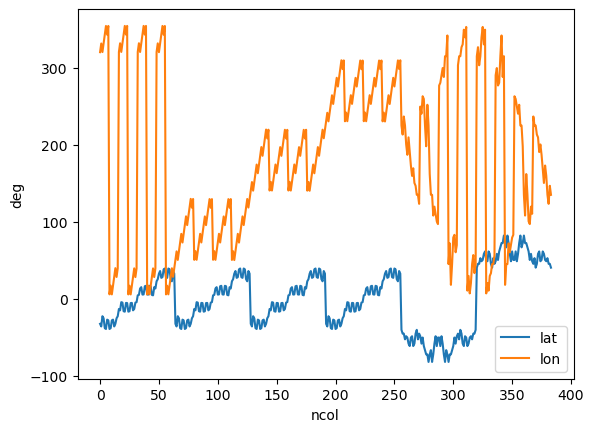

In [12]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

In [13]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


Look, the dataset is on an unstructured grid.

It is a toy dataset which does not include continuous latitudes/longitudes coordinates

The resolution is not uniform in degree as well.

In [14]:
np.unique(ds_grid.lon.values.round(2))

array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

#### Let's change the location coordinate from index of column to multi-index (lat, lon)

In [15]:
ds_backup = ds.copy()

In [16]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds['lon'] = (('ncol'),lon.T)


In [17]:
# set multi-index for the original dataset using lat and lon
ds_multiindex = ds.set_index(index_id=["lat", "lon"])
index_id = ds_multiindex.index_id
ds_multiindex = ds_multiindex.drop('index_id')
ds_multiindex = ds_multiindex.rename({'ncol':'index_id'})
ds_multiindex = ds_multiindex.assign_coords(index_id = index_id)
ds_multiindex

<xarray.Dataset>
Dimensions:         (time: 2920, index_id: 384, lev: 60)
Coordinates:
  * time            (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * lat             (index_id) float64 -32.59 -35.99 -22.69 ... 45.34 40.39
  * lon             (index_id) float64 320.3 331.5 320.4 ... 123.3 146.7 135.0
  * index_id        (index_id) object MultiIndex
Dimensions without coordinates: lev
Data variables: (12/14)
    cam_out_FLWDS   (time, index_id) float64 ...
    cam_out_NETSW   (time, index_id) float64 ...
    cam_out_PRECC   (time, index_id) float64 ...
    cam_out_PRECSC  (time, index_id) float64 ...
    cam_out_SOLL    (time, index_id) float64 ...
    cam_out_SOLLD   (time, index_id) float64 ...
    ...              ...
    state_q0001     (time, lev, index_id) float64 ...
    state_q0002     (time, lev, index_id) float64 ...
    state_q0003     (time, lev, index_id) float64 ...
    state_t         (time, lev, index_id) float64 ...
    state_u         (time, lev, index_id) float64 ...
    state_v         (time, lev, index_id) float64 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

#### Let's first remap the (time, lat, lon) data without vertical structures

# <span style="color:blue"> I only finished processing the 2D variables please follow the below steps and create a dataset for 3D variables with lev dimension </span>.
# <span style="color:blue"> You do not need to show all the variables, use state_t, state_u and state_q0001 would be fine </span>.

In [20]:
# create a dataset with stacked (lat, lon) grids in the original dataset, all values are NaNs
time = ds.time.values

data_np = np.empty(shape=(len(time), len(np.unique(lat)),len(np.unique(lon))))
data_np[:,:] = np.nan

ds_latlon = xr.Dataset(
     data_vars={
         # v: (("time","index_id"), np.zeros([len(time), len(np.unique(lat))*len(np.unique(lon))]))
         v: (("time","lat","lon"), data_np)
         for v in ['cam_out_FLWDS','cam_out_PRECC']
     },
     coords={
         "time": ds.time,
         # "index_id": pd.MultiIndex.from_product(
         #    [np.unique(lat), np.unique(lon)], names=["lat", "lon"],),
         "lat": np.unique(lat),
         "lon": np.unique(lon),
         # "lev": ds.lev,
    },
)

ds_latlon 

<xarray.Dataset>
Dimensions:        (time: 2920, lat: 52, lon: 180)
Coordinates:
  * time           (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * lat            (lat) float64 -82.06 -72.29 -66.73 ... 66.73 72.29 82.06
  * lon            (lon) float64 5.63 5.65 5.68 5.73 ... 354.3 354.3 354.4 354.4
Data variables:
    cam_out_FLWDS  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cam_out_PRECC  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [21]:
# use multi-index so that we can assign the column data to the (lat,lon) data

ds_latlon = ds_latlon.stack(index_id=['lat','lon'])
ds_latlon

<xarray.Dataset>
Dimensions:        (time: 2920, index_id: 9360)
Coordinates:
  * time           (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * index_id       (index_id) object MultiIndex
  * lat            (index_id) float64 -82.06 -82.06 -82.06 ... 82.06 82.06 82.06
  * lon            (index_id) float64 5.63 5.65 5.68 5.73 ... 354.3 354.4 354.4
Data variables:
    cam_out_FLWDS  (time, index_id) float64 nan nan nan nan ... nan nan nan nan
    cam_out_PRECC  (time, index_id) float64 nan nan nan nan ... nan nan nan nan

In [22]:
print(len(ds_multiindex.index_id.values))
ds_latlon.sel(index_id=(-32.59, 320.27))

384


<xarray.Dataset>
Dimensions:        (time: 2920)
Coordinates:
  * time           (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
    index_id       object (-32.59, 320.27)
    lat            float64 -32.59
    lon            float64 320.3
Data variables:
    cam_out_FLWDS  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    cam_out_PRECC  (time) float64 nan nan nan nan nan ... nan nan nan nan nan

# <span style="color:blue"> please delete this cell after you finish making the below cell multiprocessing so we can save running time</span>.



In [23]:
# use tqdm to visualize the progress of this loop
# this cell takes about 20min to run, please patiently wait when it is run
# optional: you can use multiprocessing to cut the running time
        
for i in tqdm(ds_multiindex.index_id.values):
    ds_latlon.loc[{"index_id": i}] = ds_multiindex[['cam_out_FLWDS','cam_out_PRECC']].sel(index_id = i)
    

100%|██████████| 384/384 [18:36<00:00,  2.91s/it]


#### visualize the 2D maps, there are many missing values cuz the toy data does not contain all the columns

In [157]:
ds_unstack = ds_latlon.unstack('index_id')

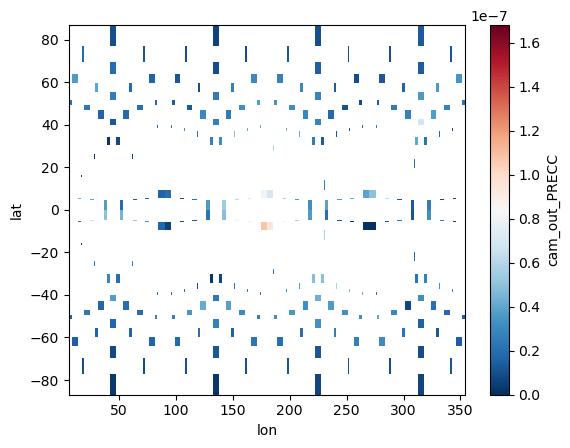

In [158]:
ds_unstack.cam_out_PRECC.mean('time').plot(cmap='RdBu_r')

#### Remap the data at a uniform 2 degree resolution for both latitude and longitude using interpolation 

For this step we will use [xesmf](https://xesmf.readthedocs.io/en/latest/) a very powerful geospatial regridding tool.

To regrid a dataarray with xesmf you need to execute the following steps:

1. Create a target grid dataset (this can also be an existing dataset)

2. Create a regridder object (using the target grid and the source dataset - e.g. the dataset that should be regridded)

3. Apply the regridder to a dataset, e.g. regridder(ds)

In [165]:
# new lat and lon grids that we finally want
nlat = np.arange(-85, 85, 5)
nlon = np.arange(0, 360, 5)
time = ds.time.values

print(len(nlat),len(nlon))

# create a nan-value xr dataset to contain new remapped & interpolated data 
data_np = np.empty([len(time), len(nlat), len(nlon)])
data_np[:,:,:] = np.nan

ds_new = xr.Dataset(
     data_vars={
         v: (("time","lat","lon"), data_np)
         for v in ['cam_out_FLWDS','cam_out_PRECC']
     },
     coords={
         "time": ds.time,
         "lat": nlat,
         "lon": nlon,
        # "lev": ds.lev,
    },
)

ds_new

34 72


<xarray.Dataset>
Dimensions:        (time: 2920, lat: 34, lon: 72)
Coordinates:
  * time           (time) object 0001-02-01 12:00:00 ... 0009-01-31 12:00:00
  * lat            (lat) int64 -85 -80 -75 -70 -65 -60 -55 ... 55 60 65 70 75 80
  * lon            (lon) int64 0 5 10 15 20 25 30 ... 330 335 340 345 350 355
Data variables:
    cam_out_FLWDS  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    cam_out_PRECC  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

#### Conservative interpolation method needs bounding coordinates


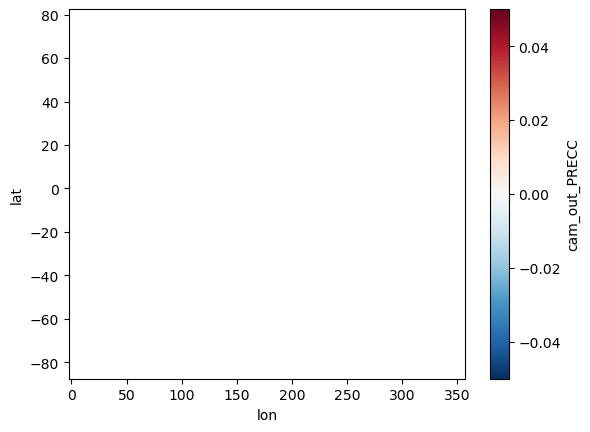

In [172]:
# Assign bounding coordinates
lon_boundary = np.hstack([ds_new.coords['lon'].data - 1, ds_new.coords['lon'][-1].data + 1])
lat_boundary = np.hstack([ds_new.coords['lat'].data - 1, ds_new.coords['lat'][-1].data + 1])

grid_lowres = ds_new.copy()
grid_lowres.coords['lon_b'] = xr.DataArray(lon_boundary, dims=['lon_b'])
grid_lowres.coords['lat_b'] = xr.DataArray(lat_boundary, dims=['lat_b'])

lon_boundary = np.hstack([ds_unstack.coords['lon'].data - 1, ds_unstack.coords['lon'][-1].data + 1])
lat_boundary = np.hstack([ds_unstack.coords['lat'].data - 1, ds_unstack.coords['lat'][-1].data + 1])

grid_highres = ds_unstack.copy()
grid_highres.coords['lon_b'] = xr.DataArray(lon_boundary, dims=['lon_b'])
grid_highres.coords['lat_b'] = xr.DataArray(lat_boundary, dims=['lat_b'])

# create a regridder using the conservative method and map the data
regridder = xe.Regridder(grid_highres, grid_lowres, 'conservative') #since this is global we need to pass periodic
ds_regrid = regridder(ds_unstack)
df_regrid.cam_out_PRECC.mean('time').plot(cmap='RdBu_r')

#### Or using linear interpolation

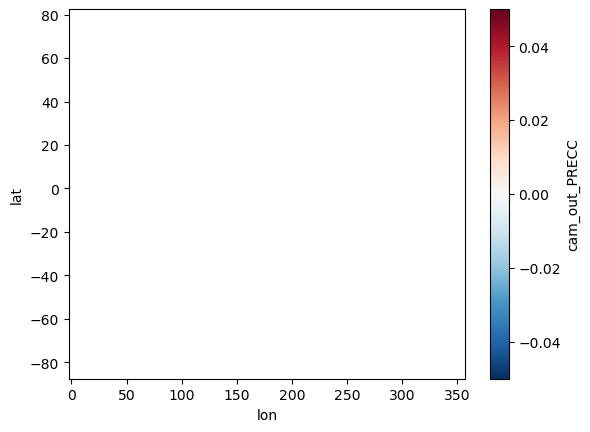

In [171]:
# bilinear methods
regridder = xe.Regridder(ds_unstack, ds_new, 'bilinear', periodic=True) #since this is global we need to pass periodic
df_regrid = regridder(ds_unstack)
df_regrid.cam_out_PRECC.mean('time').plot(cmap='RdBu_r')

### Now, analysis and visualization can be done as usual using xarray


#### [Analysis 1] Global Precipitation - We can use the original dataset to calculate global mean time series

Note it is the weighted average mean based on the area of each atmos grid/column

The unit for precipitation is m/s.

In [ ]:
# total precipitation = rainfall + snowfall
PRECT = ds['cam_out_PRECC'] + ds['cam_out_PRECSC']

# area-weighted global mean PRECT
# required concept: avg weights, broadcast, resampling
PRECT_mean = (PRECT * (ds['area']/ds['area'].sum())).sum('ncol')
PRECT_mean_daily = PRECT_mean.resample(time='1D').mean('time')
PRECT_mean_monthly = PRECT_mean.resample(time='1M').mean('time')

# visualization
fig, ax = plt.subplots()
PRECT_mean.plot(label='instantaneous', ax=ax)
PRECT_mean_daily.plot(label='daily mean', ax=ax)
PRECT_mean_monthly.plot(label='monthly mean', ax=ax)
ax.legend()